# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [40]:
# # Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

### Import packages

In [41]:
from load_data import load_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import seaborn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Classifiers and kernels

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from ROC_curve import plot_roc_curve as ROC

from prep_module import prep

### Loading data and splitting

In [42]:


data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

features = data.drop(columns=['label'])
label = data.label


# Splitting data in train and test group
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.2, stratify=label)


def binner(y, class1):
  y_bin = []
  for val in y:
    if val == class1:
      y_bin.append(0)
    else:
      y_bin.append(1) 
  return y_bin
  
y_train_bin = binner(y_train, 'T12') # make binary y_score
y_test_bin = binner(y_test, 'T12')

The number of samples: 113
The number of columns: 160


## Preprocessing

### Removing outliers

In [43]:
# Create the dataframe
outlier_feat = []
for feature in X_train.columns:
    # IQR
    Q1 = np.percentile(X_train[feature], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(X_train[feature], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
 
    if not IQR == 0:
        # Upper bound
        X_train.loc[X_train[feature] > (Q3+1.5*IQR),feature] = Q3
        # Lower bound
        X_train.loc[X_train[feature] < (Q1-1.5*IQR),feature] = Q1


for feature in X_test.columns:
    
    # IQR
    Q1 = np.percentile(X_test[feature], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(X_test[feature], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
    
    if not IQR == 0:
        # Upper bound
        X_test.loc[X_test[feature] > (Q3+1.5*IQR),feature] = Q3
        # Lower bound
        X_test.loc[X_test[feature] < (Q1-1.5*IQR),feature] = Q1


/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Scaling

In [44]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = features.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = features.columns)


## Feature selection

### LASSO

/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00463856219317192, tolerance: 0.0044
  model = cd_fast.enet_coordinate_descent(
/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005275510216645235, tolerance: 0.0044
  model = cd_fast.enet_coordinate_descent(
/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005991518151685005, tolerance: 0.0044
  model = cd_fast.enet_coordinate_descent(
/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/sklearn

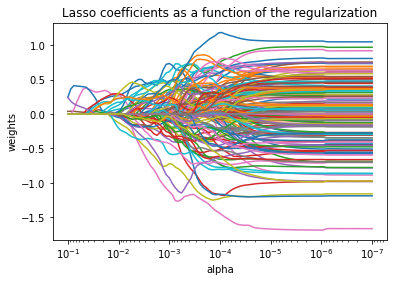

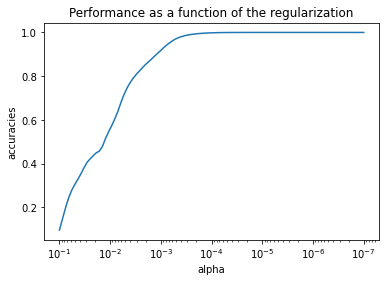

In [45]:
# Construct classifiers
coefs = []
accuracies = []
times = []

n_alphas = 100
alphas = np.logspace(-7, -1, n_alphas)

for a in alphas:
    # Fit classifier
    clf = Lasso(alpha=a, fit_intercept=False)
    clf.fit(X_train_scaled, y_train_bin) 
    y_pred = clf.predict(X_test_scaled)
    
    # Append statistics
    accuracy = clf.score(X_train_scaled,y_train_bin)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)

# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
plt.show()

#### Select features

In [46]:
selector = SelectFromModel(estimator=Lasso(alpha=10**(-6)), threshold='median')
selector.fit(X_train_scaled, y_train_bin)
n_original = X_train_scaled.shape[1]
X_train_fs = selector.transform(X_train_scaled)
X_test_fs = selector.transform(X_test_scaled)
n_selected = X_train_fs.shape[1]
print(f"Selected {n_selected} from {n_original} features.")

Selected 80 from 159 features.


/Users/bramschalkwijk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003931779979329691, tolerance: 0.002248888888888889
  model = cd_fast.enet_coordinate_descent(


## PCA

In [47]:
N_COMP = .9
pca = PCA(n_components=N_COMP)
pca.fit(X_train_fs)
X_train_pca = pca.transform(X_train_fs)
X_test_pca = pca.transform(X_test_fs)

print(f'Number of features extracted from the PCA: {X_test_pca.shape[1]}')


Number of features extracted from the PCA: 23


# Classifier

In [48]:
# from prep_module import prep
# X_train_pca, y_train, y_train_bin, X_test_pca, y_test, y_test_bin = prep(features, label)

#### SVM

Best classifier: n=SVC(C=0.28, probability=True)
Best classifier: n=SVC(C=0.61, probability=True)
Best classifier: n=SVC(C=0.8, probability=True)
        auc                              n         set
0  0.903226  SVC(C=0.28, probability=True)   train_opt
1  0.840000  SVC(C=0.28, probability=True)  validation
2  0.956618  SVC(C=0.61, probability=True)   train_opt
3  0.857778  SVC(C=0.61, probability=True)  validation
4  0.991111   SVC(C=0.8, probability=True)   train_opt
5  0.732143   SVC(C=0.8, probability=True)  validation


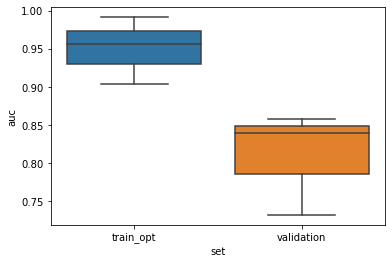

In [51]:
# Create a 3 fold stratified CV iterator
cv_3fold = model_selection.StratifiedKFold(n_splits=3)
results = []
best_cls = []
y_train_a = y_train.to_numpy()

# Loop over the folds
for train_opt_index, validation_index in cv_3fold.split(X_train_pca,y_train_a):
    # Split the data properly
    X_train_opt = X_train_pca[train_opt_index]
    y_train_opt = y_train_a[train_opt_index]
    
    X_validation = X_train_pca[validation_index]
    y_validation = y_train_a[validation_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {
        # 'coef0':list(np.linspace(0.01,1,11)),
        'C':list(np.linspace(0.01,1,100)),
        # 'kernel' : ['linear','sigmoid'],
        # 'gamma' : ['scale','auto'],
        # 'degree' : [1, 2, 3, 4, 5]
        
    }
    svm_clf = SVC(probability=True)
    cv_3fold = model_selection.StratifiedKFold(n_splits=3)
    grid_search = model_selection.GridSearchCV(svm_clf, parameters, cv=cv_3fold, scoring='roc_auc')
    grid_search.fit(X_train_opt, y_train_opt)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: n={clf}')
    best_cls.append(clf)
    
    # Test the classifier on the train_opt data
    probabilities_train_opt = clf.predict_proba(X_train_opt)
    scores_train_opt = probabilities_train_opt[:, 1]
    
    # Get the auc
    auc_train_opt = metrics.roc_auc_score(y_train_opt, scores_train_opt)
    results.append({
        'auc': auc_train_opt,
        'n': clf,
        'set': 'train_opt'
    })

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_validation)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_validation, scores)
    results.append({
        'auc': auc,
        'n': clf,
        'set': 'validation'
    })
    

    
# Create results dataframe and plot it
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

# optimal_n = int(np.median(best_cls))
# print(f"The optimal N={optimal_n}")
print(results)


In [ ]:
acc = []

#### Optimization

In [ ]:
## Optimization
### KNN
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
X_train_pca = X_train_pca
y_train_a = y_train.to_numpy()

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca,y_train_a):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    y_validation = y_train_a[validation_index]
    
    X_test_op = X_train_pca[test_index]
    y_test_op = y_train_a[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 31, 2))}
    knn = KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test_op)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test_op, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
# seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")
# print(results)


# Use the optimal parameters without any tuning to validate the optimal classifier
clf = KNeighborsClassifier(n_neighbors=optimal_n)

# Fit on the entire dataset
clf.fit(X_train_pca, y_train)

# Test the classifier on the indepedent replication data
probabilities = clf.predict_proba(X_test_pca)
scores = probabilities[:, 1]

# Get the auc
auc = metrics.roc_auc_score(y_test, scores)
print(f'THe AUC on the replication set is {auc} using a {clf.n_neighbors}-NN classifier')


knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train_pca, y_train)
score_train_kNN = knn.score(X_train_pca, y_train)
score_test_kNN = knn.score(X_test_pca, y_test)
print(f"Training result kNN: {score_train_kNN}")
print(f"Test result kNN: {score_test_kNN}")
acc.append(score_test_KNN)
print(acc)

### RF

In [ ]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
X_train_pca = X_train_sig
y_train_a = y_train.to_numpy()

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca,y_train_a):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    y_validation = y_train_a[validation_index]
    
    X_test = X_train_pca[test_index]
    y_test = y_train_a[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_estimators": list(range(1, 50))}
    rf = RandomForestClassifier(criterion= "gini", bootstrap = True, min_samples_leaf = 5)
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(rf, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: n={clf.n_estimators}')
    best_n_neighbors.append(clf.n_estimators)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'n': clf.n_estimators,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'n': clf.n_estimators,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")
print(results)


## ROC curve 

In [ ]:
def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)     
    
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
print(y_score.shape)
print(y_test.shape)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=12)
clf.fit(X_train_pca, y_train_bin)
y_pred = clf.predict(X_test_pca)
y_score = clf.predict_proba(X_test_pca)

score_train = clf.score(X_train_pca, y_train_bin)
score_test = clf.score(X_test_pca, y_test_bin)
print(f'Classifier: {clf} \n Score train:  {score_train} \n Score test: {score_test}')
plot_roc_curve(y_score,y_test_bin)